# Summary of Methods and Findings

The following notebook uses a template with a grid of april tags to calibrate a camera. The idea is to calculate the intrinsic and extrinsic parameters of the camera using the known values of the corners from the calibration tag grid then to use the calculated value as the initial guess for symforce's numerical optimizer by projecting points back onto the image using the calculated value and minimizing the error between the projected point and the known point to refine the calculated values of the intrinsic and extrinsic parameters of the camera. Overall, the results were good but there are many points, especially towards the edges, that do not track well. If tracked dots are going to be used as data, those errors will grow very large so a more robust estimation for the intial guess must be used.

# Set up notebook

In [1]:
# For input/output
from pathlib import Path
import json

# For numerical methods
import numpy as np

# For image processing and visualization of results
import cv2
from pupil_apriltags import Detector
import matplotlib.pyplot as plt

# For optimization with symforce
import symforce
symforce.set_epsilon_to_symbol()
import symforce.symbolic as sf
from symforce.values import Values
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
import sym

from PIL import Image

Initilizing image and template directories

In [2]:
# Base directory
data_dir = Path('data')

# Where images are read from
img_src_dir = Path(data_dir, 'calibration_images')

# Where images are written to
img_dst_dir = Path(data_dir, 'calibration_results')

# Where the calibration template is located
template_filename = Path(data_dir, 'tag36_11_grid_5x8-template.json')

converting images into png format

In [3]:
# i = 0
# for image_path in img_src_dir.iterdir():
#     i += 1
#     im = Image.open(image_path)
#     im.save('{}.png'.format(i))

# Parse images

Defining a function to get a tag with a particular ID from the template.

In [4]:
def get_tag_with_id(tag_id, template):
    for tag in template['tags']:
        if tag['tag_id'] == tag_id:
            return tag
    raise Exception(f'tag_id {tag_id} not found in template')

Loading tag grid template.

In [5]:
with open(template_filename, 'r') as f:
    template = json.load(f)

Creating a tag detector.

In [6]:
tag_detector = Detector(
    families=template['tag_family'],
    nthreads=1,
    quad_decimate=1.0,
    quad_sigma=0.0,
    refine_edges=1,
    decode_sharpening=0.,
    debug=0,
)

Detecting tags in all images.

In [7]:
# Tag corners must be no less than this number of pixels from the image border
buffer_px = 10

# We are going to create a list of views, one per image
views = []

# Iterate over all images in the source directory
for image_path in img_src_dir.iterdir():
    # Skip anything that isn't a PNG file
    # or image_path.suffix.lower() != '.jpg')
    if (not image_path.is_file()):
        continue

    # Read image as grayscale
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    
    # Detect tags
    tag_detections = tag_detector.detect(
        img,
        estimate_tag_pose=False,
        camera_params=None,
        tag_size=None,
    )

    # Get n point correspondences:
    #
    #  p (n x 3) is coordinates of each point in the tag frame
    #  q (n x 2) is coordinates of each point in the image frame
    #
    rejected_tags = []
    tags = []
    p = []
    q = []
    for d in tag_detections:
        # Reject tags with corners too close to the image boundary
        if ((d.corners[:, 0] < buffer_px).any() or
            (d.corners[:, 0] > (img.shape[1] - 1) - buffer_px).any() or
            (d.corners[:, 1] < buffer_px).any() or
            (d.corners[:, 1] > (img.shape[0] - 1) - buffer_px).any()):
            continue
        
        # Add tag to list of detected tags
        tags.append({
            'tag_id': d.tag_id,
            'corners': d.corners.tolist(),
        })

        # Add corners of tag to point correspondences
        p.extend(get_tag_with_id(d.tag_id, template)['corners'])
        q.extend(d.corners.tolist())
    
    # Make sure the lengths of p and q are consistent
    assert(len(p) == len(q))
    
    # Count the number of tags and correspondences that were found
    num_tags = len(tags)
    num_points = len(p)

    # Add to the list of views
    views.append({
        'image_name': str(image_path.name),
        'num_tags': num_tags,
        'tags': tags,
        'num_points': num_points,
        'p': p,
        'q': q,
    })
    
    # Show results
    print(f' {len(views) - 1:3d} ' +
          f': {str(image_path):30s} ' +
          f': {num_tags:3d} tags ({len(rejected_tags):3d} rejected) ' +
          f': {num_points:3d} points ')

   0 : data/calibration_images/20240216_143519.jpg :  40 tags (  0 rejected) : 160 points 
   1 : data/calibration_images/20240213_121702.jpg :  40 tags (  0 rejected) : 160 points 
   2 : data/calibration_images/20240213_121701.jpg :  40 tags (  0 rejected) : 160 points 
   3 : data/calibration_images/20240213_121704.jpg :  40 tags (  0 rejected) : 160 points 
   4 : data/calibration_images/20240213_121700.jpg :  40 tags (  0 rejected) : 160 points 
   5 : data/calibration_images/20240216_143510.jpg :  38 tags (  0 rejected) : 152 points 
   6 : data/calibration_images/20240216_143550.jpg :  40 tags (  0 rejected) : 160 points 
   7 : data/calibration_images/20240213_121655.jpg :  40 tags (  0 rejected) : 160 points 
   8 : data/calibration_images/20240213_121703.png :  40 tags (  0 rejected) : 160 points 
   9 : data/calibration_images/20240213_121658.png :  40 tags (  0 rejected) : 160 points 
  10 : data/calibration_images/20240213_121701.png :  40 tags (  0 rejected) : 160 points 

WRN: Matrix is singular.
WRN: Matrix is singular.


  11 : data/calibration_images/20240216_143547.jpg :  40 tags (  0 rejected) : 160 points 
  12 : data/calibration_images/20240213_121702.png :  40 tags (  0 rejected) : 160 points 
  13 : data/calibration_images/20240213_121658.jpg :  40 tags (  0 rejected) : 160 points 
  14 : data/calibration_images/20240213_121703.jpg :  40 tags (  0 rejected) : 160 points 
  15 : data/calibration_images/20240216_143555.jpg :  40 tags (  0 rejected) : 160 points 
  16 : data/calibration_images/20240213_121704.png :  40 tags (  0 rejected) : 160 points 
  17 : data/calibration_images/20240216_143515.jpg :  40 tags (  0 rejected) : 160 points 
  18 : data/calibration_images/20240216_143517.jpg :  40 tags (  0 rejected) : 160 points 
  19 : data/calibration_images/20240213_212553.jpg :  40 tags (  0 rejected) : 160 points 
  20 : data/calibration_images/20240216_143600.jpg :  40 tags (  0 rejected) : 160 points 
  21 : data/calibration_images/20240216_143508.jpg :  40 tags (  0 rejected) : 160 points 

**Estimate Parameters by Inspection was removed

# Estimate intrinsic and extrinsic parameters by analysis

Define a function that implements the wedge operator (skew symmetric matrix).

In [8]:
def skew(v):
    assert(type(v) == np.ndarray)
    assert(v.shape == (3,))
    return np.array([[0., -v[2], v[1]],
                     [v[2], 0., -v[0]],
                     [-v[1], v[0], 0.]])

Define a function to estimate the planar homography (i.e., $H$) between two sets of points. The "source points" (`pts_src`) are on the tag grid and are expressed in the coordinates of the world frame. The "destination points" (`pts_dst`) are in the image and are expressed in image coordinates.

In [9]:
def get_homography(p, q):
    A = []
    n = len(q)
    for i in range(n):
        u, v, w = q[i]
        A.append(np.row_stack((
            np.hstack([np.zeros(3), -w*p[i].T, v*p[i].T]),
            np.hstack([w*p[i].T, np.zeros(3), -u*p[i].T])
        )))
    A = np.array(A).reshape((2*n, 9))

    U, S, VT = np.linalg.svd(A)
    vn = VT[-1].reshape((9,1))
    assert(np.allclose(A@vn, np.zeros((2*n,1)), atol=1e-3))
    
    H = vn.reshape((3,3))
    return H/np.linalg.norm(H)


Define a function to get the homography for each view.

In [10]:
def get_homographies(views):
    homographies = []
    for view in views:
        # Get src points (tag)
        pts_src = []
        for p in view['p']:
            pts_src.append(np.append(p[:-1], [1.]))
        pts_src = np.array(pts_src)

        # Get dst points (img)
        pts_dst = []
        for q in view['q']:
            pts_dst.append(np.append(q, [1.]))
        pts_dst = np.array(pts_dst)

        # Get homography
        homographies.append(get_homography(pts_src, pts_dst))

    return np.array(homographies)

Define a function to get the intrinsic parameters (i.e., the intrinsic camera matrix $K$), given homographies.

In [11]:
def get_m(a, c):
    assert(a.shape == (3,))
    assert(c.shape == (3,))
    a1, a2, a3 = a
    c1, c2, c3 = c
    m  = np.array([a1*c1, a2*c2, a3*c3, a1*c2+a2*c1, a2*c3+a3*c2, a3*c1+a1*c3])
    return m

In [12]:
def get_intrinsic_parameters(homographies):
    M = []
    n = len(homographies)
    for i in range(n):
        h1 = homographies[i][:,0]
        h2 = homographies[i][:,1]
        h3 = homographies[i][:,2]

        Mn = np.array([get_m(h1, h2), get_m(h1, h1) - get_m(h2, h2)])
        M.append(Mn)
        
    M = np.array(M).reshape((2*n, 6))

    U, S, VT = np.linalg.svd(M)
    b1, b2, b3, b4, b5, b6 = VT[-1]

    B = np.array([[b1, b4, b6],
                  [b4, b2, b5],
                  [b6, b5, b3]])
    assert(np.allclose(B, B.T))

    A = np.linalg.cholesky(B).T
    K = np.linalg.inv(A)
   
    return K/K[-1,-1]


Define a function to get the extrinsic parameters (i.e., the camera pose for each view), given homographies and intrinsic parameters.

In [13]:
def get_extrinsic_parameters(homographies, K):
    K_inv = np.linalg.inv(K)
    n = len(homographies)
    poses = []

    for i in range(n):
        h1 = homographies[i][:,0]
        h2 = homographies[i][:,1]
        h3 = homographies[i][:,2]
        s = 1/np.linalg.norm(K_inv@h1)
        x_inC_ofW = s*K_inv@h1
        y_inC_ofW = s*K_inv@h2
        z_inC_ofW = skew(x_inC_ofW)@y_inC_ofW
        Q = np.vstack((x_inC_ofW, y_inC_ofW, z_inC_ofW)).T

        U, S, VT = np.linalg.svd(Q)
        R_inC_ofW = U@VT
        p_inC_ofW = s*K_inv@h3

        T_inC_ofW=  np.row_stack([
            np.column_stack([R_inC_ofW, p_inC_ofW]),
            np.array([0., 0., 0., 1.]),])
        poses.append(T_inC_ofW)
    return np.array(poses)

Apply code to perform intrinsic and extrinsic calibration.

In [14]:
homographies = get_homographies(views)
K = get_intrinsic_parameters(homographies)
poses = get_extrinsic_parameters(homographies, K)

Show results.

In [15]:
with np.printoptions(linewidth=150, formatter={'float': lambda x: f'{x:10.4f}'}):
    print('K')
    print(K)
    print('')

for view, pose in zip(views, poses):
    with np.printoptions(linewidth=150, formatter={'float': lambda x: f'{x:10.4f}'}):
        print(f'Camera pose for image {view["image_name"]}')
        print(pose)
        print('')

K
[[ 4218.2491     2.2201  1593.6232]
 [    0.0000  4224.9318  2032.7124]
 [    0.0000     0.0000     1.0000]]

Camera pose for image 20240216_143519.jpg
[[   -0.0170    -0.9998     0.0053     0.0710]
 [   -0.9945     0.0164    -0.1033     0.1071]
 [    0.1032    -0.0070    -0.9946    -0.2940]
 [    0.0000     0.0000     0.0000     1.0000]]

Camera pose for image 20240213_121702.jpg
[[   -0.0057    -0.9978     0.0665     0.0792]
 [   -1.0000     0.0056    -0.0011     0.1187]
 [    0.0008    -0.0665    -0.9978    -0.2842]
 [    0.0000     0.0000     0.0000     1.0000]]

Camera pose for image 20240213_121701.jpg
[[   -0.0087    -0.9953     0.0968     0.0862]
 [   -1.0000     0.0090     0.0022     0.1176]
 [   -0.0030    -0.0967    -0.9953    -0.2821]
 [    0.0000     0.0000     0.0000     1.0000]]

Camera pose for image 20240213_121704.jpg
[[   -0.0023    -0.9997     0.0257     0.0692]
 [   -0.9984     0.0038     0.0564     0.1218]
 [   -0.0564    -0.0255    -0.9981    -0.2729]
 [    0.0

# Estimate intrinsic and extrinsic parameters by optimization

Write a symbolic function that projects a point into the image.

In [16]:
def projection(
    T: sf.Pose3,
    p: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
) -> sf.V2:
    return sf.V2((T*p)[0]*fx/(T*p)[2] + cx, (T*p)[1]*fy/(T*p)[2] + cy)

Write a symbolic function that computes the difference between a projected point and an image point.

In [17]:
def projection_residual(
    T: sf.Pose3,
    p: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
) -> sf.V2:
    return sf.V2([q[0] - ((T*p)[0]*fx/(T*p)[2] + cx), q[1] - ((T*p)[1]*fy/(T*p)[2] + cy)])

Lambdify these two functions so they can be evaluated numerically.

In [18]:
projection_num = symforce.util.lambdify(projection)
projection_residual_num = symforce.util.lambdify(projection_residual)

Create initial values for optimization.

In [19]:
initial_values = Values(
    views=[],               # <-- fill this list with initial values specific to each view
    fx=K[0, 0],             # <-- initial guess at fx
    fy=K[1, 1],             # <-- initial guess at fy
    cx=K[0, 2],             # <-- initial guess at cx
    cy=K[1, 2],             # <-- initial guess at cy
    epsilon=sym.epsilon,    # <-- constant parameter required by symforce
)

# Iterate over each view (along with each camera pose estimate)
for view, pose in zip(views, poses):
    view_values = Values(
        T=sym.Pose3(        # <-- initial guess at camera pose
            R=sym.Rot3.from_rotation_matrix(pose[0:3, 0:3]),
            t=pose[0:3, 3],
        ),
        matches=[],         # <-- fill this list with initial values specific to each match
    )

    # Iterate over each match (i.e., each point correspondence)
    for p, q in zip(view['p'], view['q']):
        view_values['matches'].append(Values(p=np.array(p), q=np.array(q)))
    
    # Append the initial values we just created to the list of views
    initial_values['views'].append(view_values)

Create factors for optimization.

In [20]:
factors = []
for i_view, view in enumerate(initial_values['views']):
    for i_match, match in enumerate(view['matches']):
        factors.append(Factor(
            residual=projection_residual,
            keys=[
                f'views[{i_view}].T',
                f'views[{i_view}].matches[{i_match}].p',
                f'views[{i_view}].matches[{i_match}].q',
                'fx',
                'fy',
                'cx',
                'cy',
                'epsilon',
            ]
        ))

Create optimizer.

In [21]:
optimized_keys = ['fx', 'fy', 'cx', 'cy',]
for i_view, view in enumerate(initial_values['views']):
    optimized_keys.append(f'views[{i_view}].T')
optimizer = Optimizer(
    factors=factors,
    optimized_keys=optimized_keys,
    debug_stats=True,
    params=Optimizer.Params(
        iterations=100,
    ),
)

Run optimizer.

In [22]:
result = optimizer.optimize(initial_values)
assert(result.status == Optimizer.Status.SUCCESS)

[2024-04-03 17:15:10.761] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 35456.128/0.000/30095.088, rel reduction: 0.15120
[2024-04-03 17:15:13.496] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 30095.087/0.000/30069.744, rel reduction: 0.00084
[2024-04-03 17:15:16.169] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 30069.745/0.000/30058.354, rel reduction: 0.00038
[2024-04-03 17:15:18.735] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 30058.353/0.000/30040.008, rel reduction: 0.00061
[2024-04-03 17:15:21.429] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 30040.007/0.000/29986.391, rel reduction: 0.00178
[2024-04-03 17:15:24.067] [info] LM<sym::Optimize> [iter    5] lambda: 9.766e-04, error prev/linear/new: 29986.390/0.000/29901.307, rel reduction: 0.00284
[2024-04-03 17:15:26.901] [info] LM<sym::Optimize> [iter    6] lambda:

# Visualize results

Show sum-squared error.

In [23]:
# Compute all errors before optimization
initial_errors = []
for view in result.initial_values['views']:
    for match in view['matches']:
        initial_errors.append(np.linalg.norm(projection_residual_num(
            view['T'],
            match['p'],
            match['q'],
            result.initial_values['fx'],
            result.initial_values['fy'],
            result.initial_values['cx'],
            result.initial_values['cy'],
            result.initial_values['epsilon'],
        )))
initial_errors = np.array(initial_errors)

# Compute all errors after optimization
final_errors = []
for view in result.optimized_values['views']:
    for match in view['matches']:
        final_errors.append(np.linalg.norm(projection_residual_num(
            view['T'],
            match['p'],
            match['q'],
            result.optimized_values['fx'],
            result.optimized_values['fy'],
            result.optimized_values['cx'],
            result.optimized_values['cy'],
            result.optimized_values['epsilon'],
        )))
final_errors = np.array(final_errors)

# Compute sum-squared errors
print(f'Sum-squared error (halved), before optimization: {0.5 * np.sum(initial_errors**2):.1f} pixels')
print(f'Sum-squared error (halved), after optimization: {0.5 * np.sum(final_errors**2):.1f} pixels')
assert(np.isclose(0.5 * np.sum(final_errors**2), result.error()))

Sum-squared error (halved), before optimization: 35456.1 pixels
Sum-squared error (halved), after optimization: 29855.7 pixels


Show error histogram.

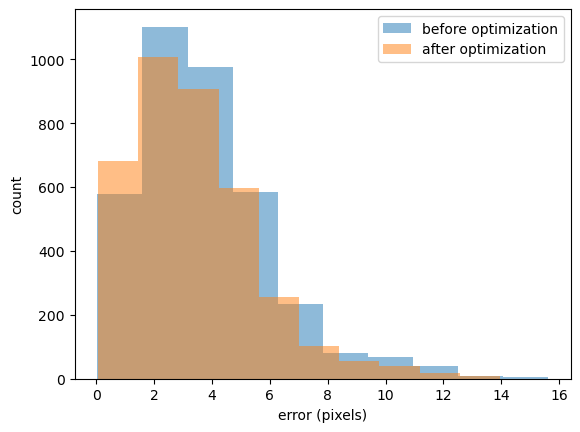

In [24]:
fig, ax = plt.subplots(1, 1)
ax.hist(initial_errors, alpha=0.5, label='before optimization')
ax.hist(final_errors, alpha=0.5, label='after optimization')
ax.legend()
ax.set_xlabel('error (pixels)')
ax.set_ylabel('count')
plt.show()

Save annotated images to show match (hopefully) between given and projected image points.

In [25]:
# Choose parameters for annotation
text_offset = 10
mark_radius = 10
text_scale = 1
text_thickness = 3
text_font = cv2.FONT_HERSHEY_SIMPLEX
text_linetype = cv2.LINE_AA

# Iterate over all views
for view_data, view_initial, view_final in zip(views, result.initial_values['views'], result.optimized_values['views']):
    # Image paths
    img_src_path = Path(img_src_dir, view_data['image_name'])
    img_dst_path = Path(img_dst_dir, view_data['image_name'])
    print(f'{img_src_path} -> {img_dst_path}')

    # Read image as BGR
    img = cv2.imread(str(img_src_path))
    
    # Add annotations to image
    for i_match, match in enumerate(view_final['matches']):
        # Get the image point that was given
        q = match['q']
        
        # Get the image point that was computed by projection (before optimization)
        q_initial = projection_num(
            view_initial['T'],
            match['p'],
            result.initial_values['fx'],
            result.initial_values['fy'],
            result.initial_values['cx'],
            result.initial_values['cy'],
            result.initial_values['epsilon'],
        )

        # Get the image point that was computed by projection (after optimization)
        q_final = projection_num(
            view_final['T'],
            match['p'],
            result.optimized_values['fx'],
            result.optimized_values['fy'],
            result.optimized_values['cx'],
            result.optimized_values['cy'],
            result.optimized_values['epsilon'],
        )

        # Mark and number the image point that was given
        cv2.circle(
            img,
            (int(q[0]), int(q[1])),
            2 * mark_radius,
            (0, 0, 255),
            -1,
        )
        cv2.putText(
            img,
            f'{i_match}',
            (int(q[0]) + text_offset, int(q[1]) + 4 * text_offset),
            text_font,
            text_scale,
            (0, 0, 255),
            text_thickness,
            text_linetype,
        )
        
        # Mark and number the image point that was computed by projection (before optimization)
        cv2.circle(
            img,
            (int(q_initial[0]), int(q_initial[1])),
            int(1.5 * mark_radius),
            (0, 255, 0),
            -1,
        )
        cv2.putText(
            img,
            f'{i_match}',
            (int(q_initial[0]) - 4 * text_offset, int(q_initial[1]) - 2 * text_offset),
            text_font,
            text_scale,
            (0, 255, 0),
            text_thickness,
            text_linetype,
        )

        # Mark and number the image point that was computed by projection (after optimization)
        cv2.circle(
            img,
            (int(q_final[0]), int(q_final[1])),
            mark_radius,
            (255, 0, 0),
            -1,
        )
        cv2.putText(
            img,
            f'{i_match}',
            (int(q_final[0]) + text_offset, int(q_final[1]) - 2 * text_offset),
            text_font,
            text_scale,
            (255, 0, 0),
            text_thickness,
            text_linetype,
        )

    cv2.imwrite(str(img_dst_path), img)

data/calibration_images/20240216_143519.jpg -> data/calibration_results/20240216_143519.jpg
data/calibration_images/20240213_121702.jpg -> data/calibration_results/20240213_121702.jpg
data/calibration_images/20240213_121701.jpg -> data/calibration_results/20240213_121701.jpg
data/calibration_images/20240213_121704.jpg -> data/calibration_results/20240213_121704.jpg
data/calibration_images/20240213_121700.jpg -> data/calibration_results/20240213_121700.jpg
data/calibration_images/20240216_143510.jpg -> data/calibration_results/20240216_143510.jpg
data/calibration_images/20240216_143550.jpg -> data/calibration_results/20240216_143550.jpg
data/calibration_images/20240213_121655.jpg -> data/calibration_results/20240213_121655.jpg
data/calibration_images/20240213_121703.png -> data/calibration_results/20240213_121703.png
data/calibration_images/20240213_121658.png -> data/calibration_results/20240213_121658.png
data/calibration_images/20240213_121701.png -> data/calibration_results/20240213